**Project: Finding Lane Lines on the Road**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
import cv2
import math
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 255, 0], thickness=6):
    """
    This functions calucates slopes of each line and based on slope
    decide right side lane of left side lane.
    
    To extrapolate, gets max_X and max_Y from each side and draws lines
    To avoid false negatives, right slope x and left slope x adjust to default
    minimum value
    """

    right_slopes = []
    left_slopes = []
    right_lines = []
    left_lines = []
    max_right_x = 0;
    max_right_y = 0;
    min_right_x = img.shape[1];
    min_right_y = img.shape[0];
    right_x = []
    right_y = []
    max_left_x = 0;
    max_left_y = 0;
    min_left_x = img.shape[1];
    min_left_y = img.shape[0];
    left_x = []
    left_y = []
    for line in lines:
      
        for x1,y1,x2,y2 in line:
           # cv2.line(img, (x1, y1), (x2, y2), color, thickness)           
            x = [x1, x2]
            y = [y1, y2]

            slope = (y2 - y1) / (x2 - x1)
           # print (slope)
            if slope > 0:
     #           print (line)
                right_x = right_x + x
                right_y = right_y + y
                right_slopes.append(slope)
                right_lines.append(line)
                if x2 > max_right_x:
                    max_right_x = x2
                if y2 > max_right_y:
                    max_right_y = y2
                if x1 < min_right_x:
                    min_right_x = x1
                if y1 < min_right_y:
                    min_right_y = y1
                    
            else:
    #            print (line)
                left_x = left_x + x
                left_y = left_y + y
                left_slopes.append(slope)
                left_lines.append(line)
                if x2 > max_left_x:
                    max_left_x = x2
                if y1 > max_left_y:
                    max_left_y = y1
                if x1 < min_left_x:
                    min_left_x = x1
                if y2 < min_left_y:
                    min_left_y = y2
    #adjust X
    
    if min_right_x < (img.shape[1]/2 + 20):
        min_right_x = int(img.shape[1]/2 + 20);
    if max_left_x > (img.shape[1]/2 - 20):
        max_left_x = int(img.shape[1]/2 - 20);
        
    #Draw line
    cv2.line(img, (min_right_x, min_right_y), (max_right_x, max_right_y), color, thickness)
    cv2.line(img, (min_left_x, max_left_y), (max_left_x, min_left_y), color, thickness)
  
  
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


In [2]:
def process_image(img):
    #read image and convert to gray
    #plt.imshow(img)

    # First convert image to GrayScale
    gray = grayscale(img)
    #plt.imshow(gray, cmap='gray')
    
        #Detect egdes using canny

    #Gaussian smoothing / blurring
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    #plt.imshow(blur_gray, cmap='gray')

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(edges, cmap='Greys_r')
    
    #Mask image using four sided polygon with vertices
    imshape = img.shape
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(50, height), #Left_bottom
                          (width - 50, height), #Right_bottom
                          (width/2 + 20, height/2 + 50), #Right middle
                          (width/2 - 20, height/2 + 50)]], np.int32) #Left middle
    
    masked_img = region_of_interest(edges, vertices)
    #plt.imshow(masked_img)

      # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 150 #minimum number of pixels making up a line
    max_line_gap = 150    # maximum gap in pixels between connectable line segments

    #Find and draw hough lines with hough paramteres
    line_draw_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.imshow(line_draw_img)
    #Combine canny edges with line draw image
    lines_edges = cv2.addWeighted(img, 0.8, line_draw_img, 1, 0) 
    return lines_edges  

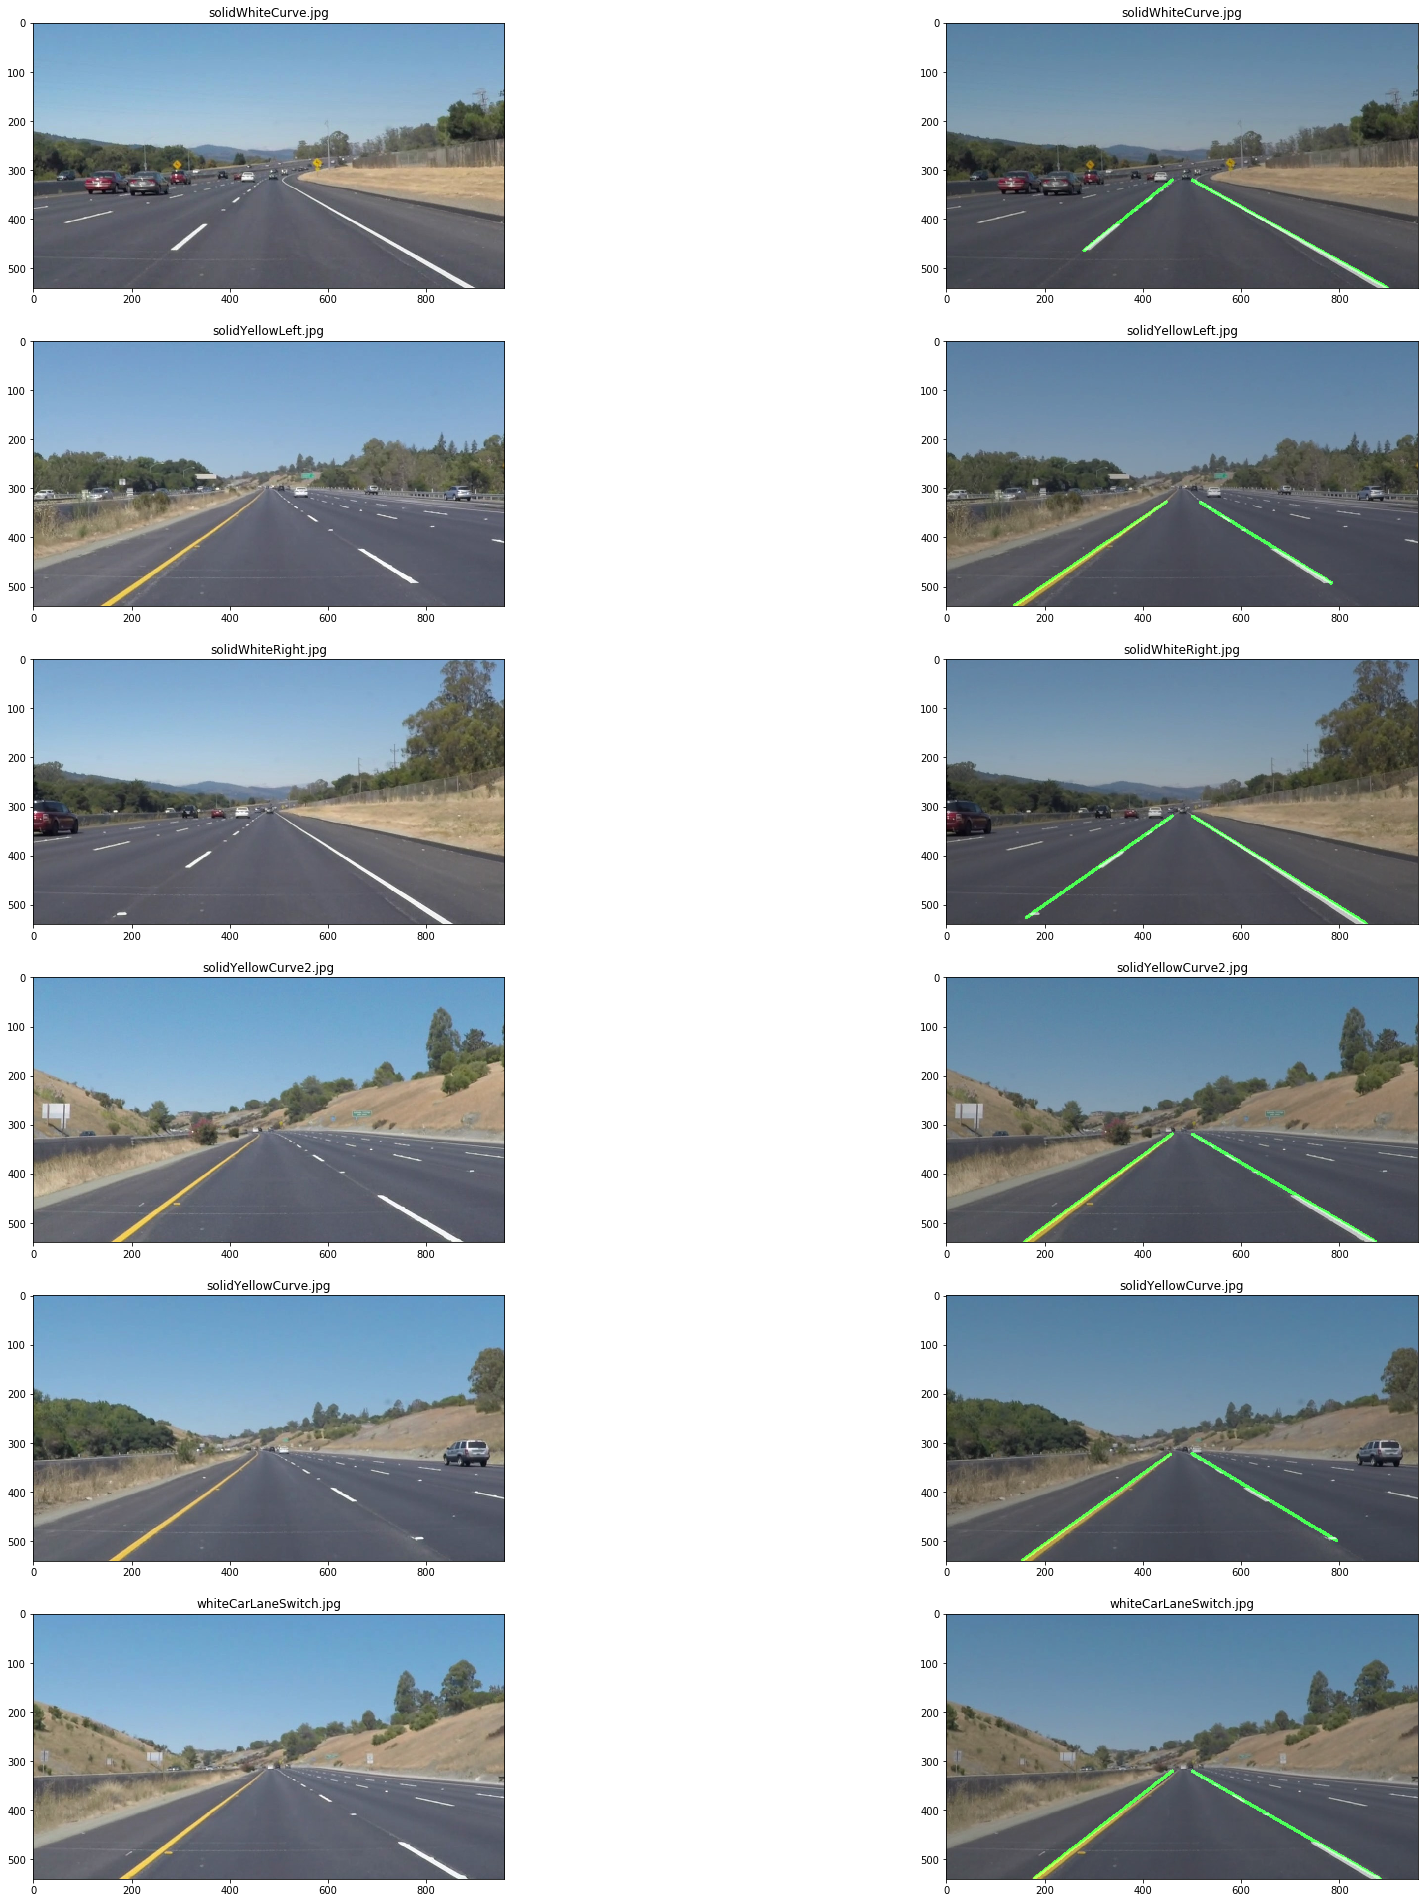

In [3]:
dirs = os.listdir("test_images/")
num = 1
i = 1
for n in dirs:
    num = num + 1
plt.figure(figsize=[30, 40])
for file in dirs:
    #Read image
    in_img = "test_images/"+file
    img = mimg.imread(in_img)
    
    #plot inout image in X axis
    plt.subplot(num, 2, i)
    plt.title(file)
    plt.imshow(img)
    i = i + 1

    #Process image
    lines_edges = process_image(img)
    
    #Plot output image on Y axis
    plt.subplot(num, 2, i)
    plt.title(file)
    plt.imshow(lines_edges)
    i = i + 1
   # break

In [4]:

white_output = 'test_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


[MoviePy] >>>> Building video test_output/solidWhiteRight.mp4
[MoviePy] Writing video test_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 77.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/solidWhiteRight.mp4 

CPU times: user 9.61 s, sys: 284 ms, total: 9.9 s
Wall time: 3.16 s


In [5]:

yellow_output = 'test_output/challenge.mp4.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
yellow_clip = clip1.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))


[MoviePy] >>>> Building video test_output/challenge.mp4.mp4
[MoviePy] Writing video test_output/challenge.mp4.mp4


100%|██████████| 251/251 [00:06<00:00, 42.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/challenge.mp4.mp4 

CPU times: user 13.8 s, sys: 408 ms, total: 14.2 s
Wall time: 6.9 s


In [6]:
yellow_output = 'test_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_output/solidYellowLeft.mp4
[MoviePy] Writing video test_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 75.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/solidYellowLeft.mp4 

CPU times: user 30.3 s, sys: 720 ms, total: 31 s
Wall time: 9.41 s
